In [46]:
#导入必要的库文件
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
import math

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device=torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用设备:{device}")

使用设备:mps


In [47]:
#位置编码
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=5000):
        """
        参数解释
        d_model: 输入的维度
        max_len: 最大序列长度
        """
        super(PositionalEncoding,self).__init__()

        pe=torch.zeros(max_len,d_model)
        position=torch.arange(0,max_len,dtype=torch.float).unsqueeze(1)

        div_term=torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)/d_model))

        pe[:,0::2]=torch.sin(position*div_term) # 偶数位置
        pe[:,1::2]=torch.cos(position*div_term) # 奇数位置

        pe=pe.unsqueeze(0).transpose(0,1)
        self.register_buffer('pe',pe)

    def forward(self,x):
        """x: [seq_len,batch_size,d_model]"""
        return x+self.pe[:x.size(0),:]

In [48]:
#transformer翻译模块
class TransformerTranslator(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1, max_seq_length=5000):
        """
        参数含义为
        src_vocab_size: 源语言字典大小
        tgt_vocab_size: 目标语言字典大小
        d_model: 模型维度
        nhead: 多头注意力的头数
        num_encoder_layers: 编码器的层数
        num_decoder_layers: 解码器的层数
        dim_feedforward: 前向传播的维度
        dropout: 随机失活概率
        max_seq_length: 最大序列长度
        """
        super(TransformerTranslator,self).__init__()
        self.d_model=d_model
        self.src_vocab_size=src_vocab_size
        self.tgt_vocab_size=tgt_vocab_size

        #源语言嵌入层以及位置编码
        self.src_embedding=nn.Embedding(src_vocab_size,d_model)
        self.src_position_encoding=PositionalEncoding(d_model,max_seq_length)

        #目标语言嵌入层以及位置编码
        self.tgt_embedding=nn.Embedding(tgt_vocab_size,d_model)
        self.tgt_position_encoding=PositionalEncoding(d_model,max_seq_length)

        #transformer
        self.transformer=nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False
        )
        self.output_layer=nn.Linear(d_model,tgt_vocab_size)

        # 初始化参数
        self.init_weights()
    def init_weights(self):
        initrange=0.1
        self.src_embedding.weight.data.uniform_(-initrange,initrange)
        self.tgt_embedding.weight.data.uniform_(-initrange,initrange)
        self.output_layer.weight.data.uniform_(-initrange,initrange)
        self.output_layer.bias.data.zero_()
    def forward(self,src,tgt,src_mask=None,tgt_mask=None,src_key_padding_mask=None,tgt_key_padding_mask=None,memory_key_padding_mask=None):
        """
        前向传播
        src: 源序列
        tgt: 目标序列
        """
        # 嵌入层
        src_embedded=self.src_embedding(src)*math.sqrt(self.d_model)
        tgt_embedded=self.tgt_embedding(tgt)*math.sqrt(self.d_model)
        # 编码层 positional encoding
        src_encoded=self.src_position_encoding(src_embedded)
        tgt_encoded=self.tgt_position_encoding(tgt_embedded)

        #transformer forward
        output=self.transformer(
            src_encoded,
            tgt_encoded,
            src_mask=None,
            tgt_mask=None,
            memory_mask=None,
            src_key_padding_mask=None,
            tgt_key_padding_mask=None,
            memory_key_padding_mask=None,
        )
        output=self.output_layer(output)
        return output
    
    

In [49]:
#数据预处理
class Vocabluary:
    def __init__(self,special_tokens=['<PAD>','<UNK>','<SOS>','<EOS>']):
        self.special_tokens=special_tokens
        self.word2idx={}
        self.idx2word={}
        self.vocab_size=0

        for token in special_tokens:
            self.add_token(token)
    def add_token(self,token):
        """添加词汇到词汇表中去"""
        if token not in self.word2idx:
            self.word2idx[token]=self.vocab_size
            self.idx2word[self.vocab_size]=token
            self.vocab_size+=1
    def add_sentence(self,sentence):
        """添加句子到词汇表中去"""
        for word in sentence.split():
            self.add_token(word)

    def sentence_to_indices(self,sentence,max_length=50):
        """把句子转换为索引"""
        indices=[self.word2idx.get('<SOS>',0)]
        words=sentence.split()
        for word in words:
            indices.append(self.word2idx.get(word,self.word2idx.get('<UNK>',1)))
        indices.append(self.word2idx.get('<EOS>',2))
        if max_length:
            if len(indices)<max_length:
                indices.extend([self.word2idx.get('<PAD>',3)]*(max_length-len(indices)))
            else:
                indices=indices[:max_length]
        return indices
    def indices_to_sentence(self,indices):
        """将序列转换为句子"""
        words=[]
        for idx in indices:
            if idx==self.word2idx.get('<EOS>',2):
                break
            if idx not in [self.word2idx.get('<PAD>', 0), self.word2idx.get('<SOS>', 0)]:
                words.append(self.idx2word.get(idx, '<UNK>'))
        return ' '.join(words)

In [50]:
class TranslationDataset(Dataset):
    def __init__(self,src_sentences,tgt_sentences,src_vocab,tgt_vocab,max_length=50):
        self.src_sentences=src_sentences
        self.tgt_sentences=tgt_sentences
        self.src_vocab=src_vocab
        self.tgt_vocab=tgt_vocab
        self.max_length=max_length
    def __len__(self):
        return len(self.src_sentences)
    def __getitem__(self,idx):
        src_sentence=self.src_sentences[idx]
        tgt_sentence=self.tgt_sentences[idx]

        src_indices=self.src_vocab.sentence_to_indices(src_sentence)
        tgt_indices=self.tgt_vocab.sentence_to_indices(tgt_sentence)

        return torch.tensor(src_indices),torch.tensor(tgt_indices)


In [51]:
#掩码生成模块
def generate_square_mask(sz):
    """生成自回归的掩码，防止看到未来的信息"""
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt, src_pad_idx, tgt_pad_idx):
    """创建各种掩码"""
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
    
    # 源序列掩码（填充掩码）
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)
    
    # 目标序列掩码（自回归掩码 + 填充掩码）
    tgt_mask = generate_square_mask(tgt_seq_len).to(device)
    
    # 填充掩码
    src_padding_mask = (src == src_pad_idx).transpose(0, 1)
    tgt_padding_mask = (tgt == tgt_pad_idx).transpose(0, 1)
    
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [52]:
def create_sample_data():
    """创建英文到中文的翻译数据"""
    # 英文到中文的示例数据
    english_sentences = [
        "hello world",
        "how are you",
        "good morning",
        "good evening",
        "thank you",
        "you are welcome",
        "see you later",
        "goodbye",
        "what is your name",
        "my name is john",
        "i love you",
        "i am hungry",
        "i am thirsty",
        "where is the bathroom",
        "how much is this",
        "i do not understand",
        "can you help me",
        "i need a doctor",
        "call the police",
        "happy birthday",
        "i am fine",
        "nice to meet you",
        "where are you from",
        "i am from china",
        "do you speak english",
        "yes i do",
        "no i do not",
        "what time is it",
        "it is ten o clock",
        "have a nice day"
    ]
    
    chinese_sentences = [
        "你好 世界",
        "你好吗",
        "早上好",
        "晚上好",
        "谢谢",
        "不客气",
        "再见",
        "再见",
        "你叫什么名字",
        "我叫 约翰",
        "我爱你",
        "我饿了",
        "我渴了",
        "洗手间 在哪里",
        "这个 多少钱",
        "我不明白",
        "你能 帮助 我吗",
        "我需要 医生",
        "叫 警察",
        "生日快乐",
        "我很好",
        "很高兴 认识你",
        "你来自 哪里",
        "我来自 中国",
        "你 说 英语吗",
        "是的 我说",
        "不 我不",
        "现在 几点",
        "十点",
        "祝你 一天愉快"
    ]
    
    return english_sentences, chinese_sentences


In [53]:
def train_model(model,train_data_loader,criterion,optimizer,num_epochs=100):
    """
    训练模型
    model: 模型
    train_data_loader: 训练数据
    criterion: 损失函数
    optimizer: 优化器
    num_epochs: 训练轮数
    """
    model.train()
    losses=[]
    for epoch in range(num_epochs):
        total_loss=0
        for batch_idx,(src_batch,tgt_batch) in enumerate(train_data_loader):
            src_batch=src_batch.transpose(0,1).to(device)
            tgt_batch=tgt_batch.transpose(0,1).to(device)

            tgt_input=tgt_batch[:-1,:]
            tgt_output=tgt_batch[1:,:]

            #创建掩码
            src_pad_idx=0
            tgt_pad_idx=0
            src_mask,tgt_mask,src_padding_mask,tgt_padding_mask=create_mask(src_batch,tgt_input,src_pad_idx,tgt_pad_idx)

            optimizer.zero_grad()
            output=model(
                src_batch,
                tgt_input,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                src_padding_mask
            )
            loss=criterion(output.reshape(-1,output.shape[-1]),tgt_output.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()
        avg_loss=total_loss/len(train_data_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch} Loss: {avg_loss:.4f}")
    return losses

In [54]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, max_length=50):
    """翻译单个句子"""
    model.eval()
    
    with torch.no_grad():
        # 将句子转换为索引
        src_indices = src_vocab.sentence_to_indices(sentence, max_length)
        src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(1).to(device)
        
        # 创建目标序列，以<SOS>开始
        tgt_indices = [tgt_vocab.word2idx['<SOS>']]
        tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long).unsqueeze(1).to(device)
        
        # 逐个生成目标词
        for i in range(max_length):
            # 创建掩码
            src_pad_idx = 0
            tgt_pad_idx = 0
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
                src_tensor, tgt_tensor, src_pad_idx, tgt_pad_idx)
            
            # 前向传播
            output = model(
                src_tensor, tgt_tensor,
                src_mask=src_mask, tgt_mask=tgt_mask,
                src_key_padding_mask=src_padding_mask,
                tgt_key_padding_mask=tgt_padding_mask,
                memory_key_padding_mask=src_padding_mask
            )
            
            # 获取最后一个词的概率分布
            prob = output[-1, 0, :]
            # 选择概率最高的词
            next_word = torch.argmax(prob).item()
            
            # 添加到目标序列
            tgt_indices.append(next_word)
            tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long).unsqueeze(1).to(device)
            
            # 如果生成了<EOS>，停止生成
            if next_word == tgt_vocab.word2idx.get('<EOS>', 2):
                break
                
        # 将索引转换为句子
        translated_sentence = tgt_vocab.indices_to_sentence(tgt_indices)
        return translated_sentence

In [55]:
def main():
    """主函数 - 展示完整流程"""
    print("创建英文到中文的示例数据...")
    src_sentences, tgt_sentences = create_sample_data()
    
    print("构建词汇表...")
    src_vocab = Vocabluary()
    tgt_vocab = Vocabluary()
    
    # 构建源语言和目标语言词汇表
    for sentence in src_sentences:
        src_vocab.add_sentence(sentence)
        
    for sentence in tgt_sentences:
        tgt_vocab.add_sentence(sentence)
    
    print(f"英文词汇表大小: {src_vocab.vocab_size}")
    print(f"中文词汇表大小: {tgt_vocab.vocab_size}")
    
    # 创建数据集和数据加载器
    dataset = TranslationDataset(src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_length=20)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    # 模型参数
    src_vocab_size = src_vocab.vocab_size
    tgt_vocab_size = tgt_vocab.vocab_size
    d_model = 128
    nhead = 8
    num_encoder_layers = 3
    num_decoder_layers = 3
    dim_feedforward = 512
    dropout = 0.1
    
    print("创建Transformer模型...")
    model = TransformerTranslator(
        src_vocab_size=src_vocab_size,
        tgt_vocab_size=tgt_vocab_size,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    ).to(device)
    
    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 忽略<PAD>标记
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
    
    print("开始训练...")
    losses = train_model(model, dataloader, criterion, optimizer, num_epochs=100)
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # 测试翻译
    print("\n测试翻译:")
    test_sentences = [
        "hello world",
        "how are you",
        "thank you",
        "good morning"
    ]
    
    for sentence in test_sentences:
        translated = translate_sentence(model, sentence, src_vocab, tgt_vocab)
        print(f"英文: {sentence}")
        print(f"中文翻译: {translated}")
        print("-" * 30)


创建英文到中文的示例数据...
构建词汇表...
英文词汇表大小: 63
中文词汇表大小: 50
创建Transformer模型...
开始训练...
Epoch 0 Loss: 3.4978
Epoch 1 Loss: 3.1219
Epoch 2 Loss: 3.0709
Epoch 3 Loss: 3.0362
Epoch 4 Loss: 3.0752
Epoch 5 Loss: 3.0274
Epoch 6 Loss: 2.9643
Epoch 7 Loss: 2.9753
Epoch 8 Loss: 2.8266
Epoch 9 Loss: 2.8633
Epoch 10 Loss: 2.7225
Epoch 11 Loss: 2.6804
Epoch 12 Loss: 2.5928
Epoch 13 Loss: 2.5399
Epoch 14 Loss: 2.3525
Epoch 15 Loss: 2.3310
Epoch 16 Loss: 2.2652
Epoch 17 Loss: 2.1451
Epoch 18 Loss: 2.1670
Epoch 19 Loss: 2.0910
Epoch 20 Loss: 2.0296
Epoch 21 Loss: 1.9561
Epoch 22 Loss: 1.8059
Epoch 23 Loss: 1.8029
Epoch 24 Loss: 1.6614
Epoch 25 Loss: 1.6785
Epoch 26 Loss: 1.6054
Epoch 27 Loss: 1.5118
Epoch 28 Loss: 1.4449
Epoch 29 Loss: 1.3574
Epoch 30 Loss: 1.2705
Epoch 31 Loss: 1.1800
Epoch 32 Loss: 1.1664
Epoch 33 Loss: 1.0561
Epoch 34 Loss: 0.9390
Epoch 35 Loss: 0.9204
Epoch 36 Loss: 0.7748
Epoch 37 Loss: 0.7135
Epoch 38 Loss: 0.7375
Epoch 39 Loss: 0.6423
Epoch 40 Loss: 0.5919
Epoch 41 Loss: 0.5726
Epoch 42 L

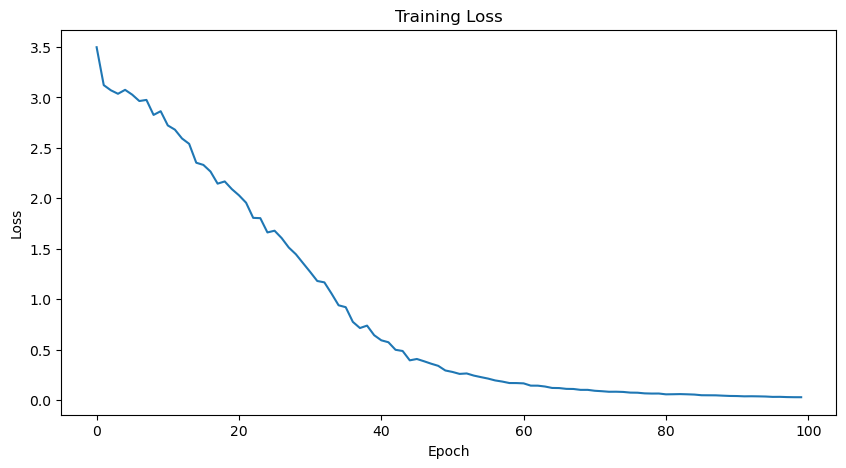


测试翻译:
英文: hello world
中文翻译: 你好 世界
------------------------------
英文: how are you
中文翻译: 你好吗
------------------------------
英文: thank you
中文翻译: 谢谢
------------------------------
英文: good morning
中文翻译: 早上好
------------------------------


In [56]:
main()